# Outlier Detection and Dimensionality Reduction with UMAP

<!--<badge>--><a href="https://colab.research.google.com/github/kuennethgroup/ml_in_ms_st25/blob/main/04_ex/2d_reduction_using_UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

## What is UMAP?

**Uniform Manifold Approximation and Projection (UMAP)** is a powerful dimension reduction technique that can be used for:
- Visualization of high-dimensional data
- General non-linear dimension reduction
- Clustering analysis
- Outlier detection

UMAP is designed to be compatible with scikit-learn's API, making it easy to use as a drop-in replacement for other dimensionality reduction techniques like t-SNE or PCA.

### Key Advantages of UMAP
- Preserves both local and global structure of the data
- Faster than t-SNE for large datasets
- Better preservation of the data's topology
- Can be used for general dimensionality reduction, not just visualization

In this tutorial, we'll use UMAP to visualize penguin data and detect patterns and potential outliers.

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# Set a consistent style for all visualizations
sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 12})

2025-11-04 13:43:42.630158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Palmer Penguins Dataset

For this tutorial, we'll use the Palmer Penguins dataset, which contains measurements from three different penguin species found in the Palmer Archipelago, Antarctica.

### The dataset includes:
- 3 penguin species (Adelie, Chinstrap, Gentoo)
- Measurements of bill length, bill depth, flipper length, and body mass
- Information about the island where each penguin was observed
- Sex and year of observation

<img src="https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/man/figures/lter_penguins.png" alt="Three penguin species" width="500"/>  

### Key Penguin Measurements
The image below shows one of the key measurements in our dataset: bill dimensions.

<img src="https://github.com/allisonhorst/palmerpenguins/blob/c19a904462482430170bfe2c718775ddb7dbb885/man/figures/culmen_depth.png?raw=true" alt="Bill dimensions diagram" width="500"/>  

## 1. Loading the Penguin Dataset

First, we'll download and load the penguin dataset from a public GitHub repository.

In [2]:
df_penguins = pd.read_csv(
    "https://raw.githubusercontent.com/allisonhorst/palmerpenguins/c19a904462482430170bfe2c718775ddb7dbb885/inst/extdata/penguins.csv"
)

# Display the dataset to understand the structure of the data
df_penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


## 2. Data Cleaning and Exploration

Before applying UMAP, we need to clean the dataset by:
1. Removing any rows with missing values
2. Understanding the distribution of penguin species

In [3]:
# Check for missing values
print("Missing values per column:")
print(df_penguins.isnull().sum())
print("\n")

# Remove rows with any missing values
df_penguins = df_penguins.dropna()
print(f"Shape after dropping missing values: {df_penguins.shape}")

# Check the distribution of penguin species
species_counts = df_penguins.species.value_counts()
print("\nPenguin species distribution:")
display(species_counts)

Missing values per column:
species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64


Shape after dropping missing values: (333, 8)

Penguin species distribution:


species
Adelie       146
Gentoo       119
Chinstrap     68
Name: count, dtype: int64

Text(0.5, 1.02, 'Relationships Between Penguin Features')

<Figure size 1200x1000 with 0 Axes>

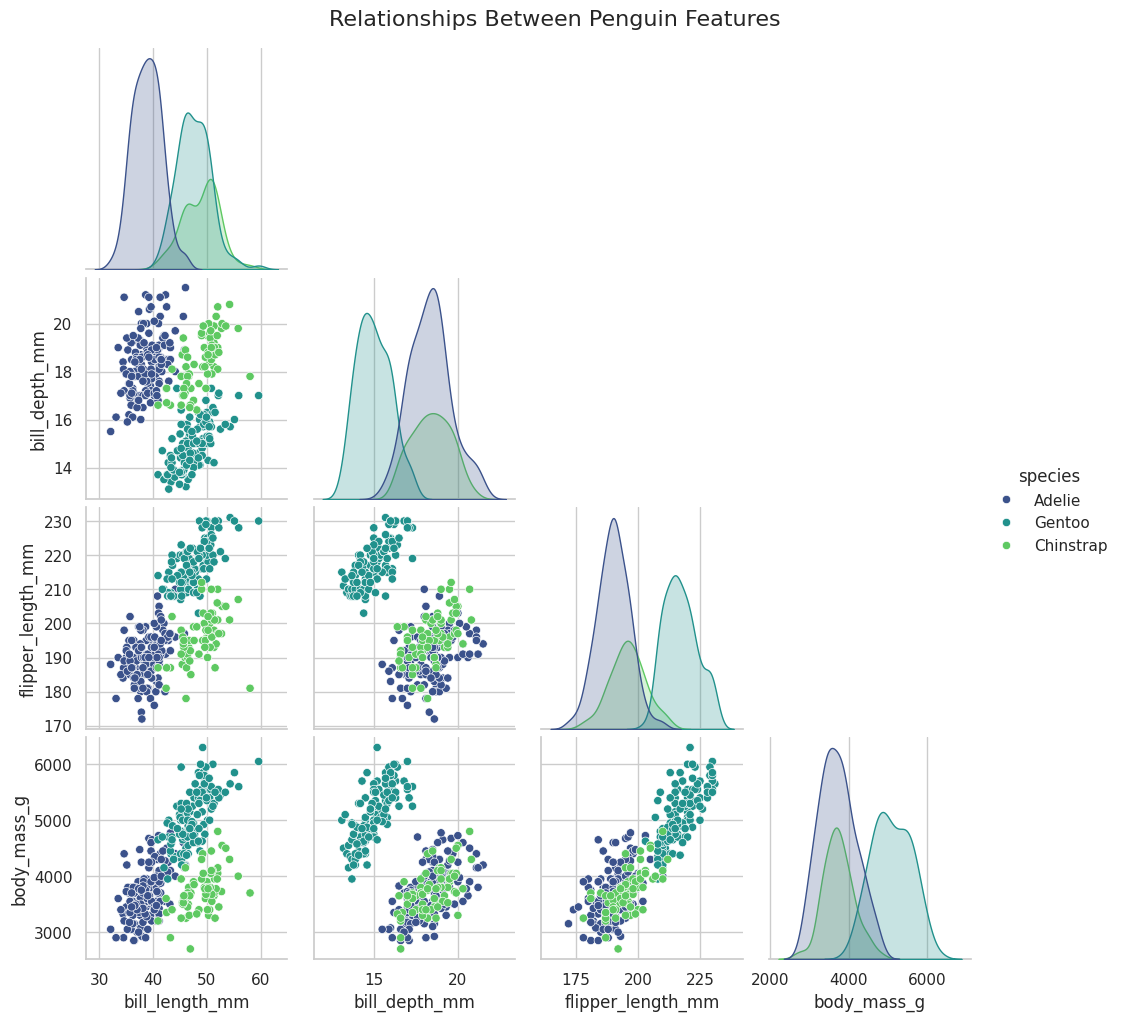

In [4]:
# Create a pairplot to visualize relationships between features
plt.figure(figsize=(12, 10))
pairplot = sns.pairplot(
    df_penguins.drop("year", axis=1),  # Drop year as it's not relevant for our analysis
    hue="species",  # Color points by penguin species
    palette="viridis",  # Use a colorblind-friendly palette
    corner=True,  # Show only the lower triangle of the grid
)
pairplot.figure.suptitle("Relationships Between Penguin Features", y=1.02, fontsize=16)


# From this visualization, we can observe:
# 1. Clear clustering by species in several feature combinations
# 2. Gentoo penguins have longer flippers and greater body mass
# 3. Adelie and Chinstrap penguins have more overlap but differ in bill dimensions

Scaler data
Mean [  43.99279279   17.16486486  200.96696697 4207.05705706]
Variance [2.98165246e+01 3.86624300e+00 1.95851762e+02 6.46425423e+05]
Original data (first 3 rows):


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


Scaled data (first 3 rows):


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,-0.896042,0.780732,-1.426752,-0.568475,male,2007
1,Adelie,Torgersen,-0.822788,0.119584,-1.069474,-0.506286,female,2007
2,Adelie,Torgersen,-0.676280,0.424729,-0.426373,-1.190361,female,2007


<Axes: >

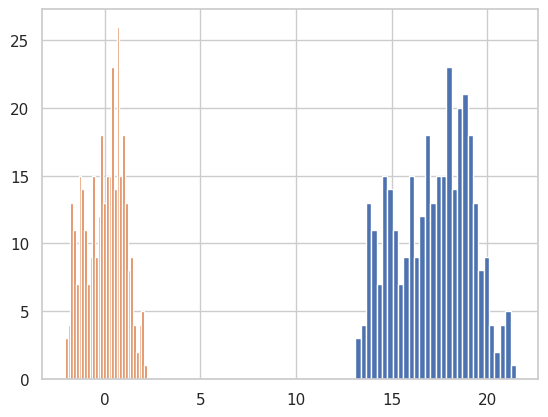

In [5]:
from scipy.stats import norm

# Extract the numerical features for dimensionality reduction
rows = [
    "bill_length_mm",
    "bill_depth_mm",
    "flipper_length_mm",
    "body_mass_g",
]
penguin_data = df_penguins[rows]

sc = StandardScaler()
scaled_penguin_data = sc.fit_transform(penguin_data)
print("Scaler data")
print(f"Mean {sc.mean_}")
print(f"Variance {sc.var_}")


# Create a new dataframe with the scaled values for visualization
df_scaled_penguin_data = df_penguins.copy()
df_scaled_penguin_data[rows] = scaled_penguin_data

print("Original data (first 3 rows):")
display(df_penguins.head(3))

print("Scaled data (first 3 rows):")
display(df_scaled_penguin_data.head(3))

df_penguins["bill_depth_mm"].hist(bins=30)
df_scaled_penguin_data["bill_depth_mm"].hist(bins=30)

<Figure size 1200x1000 with 0 Axes>

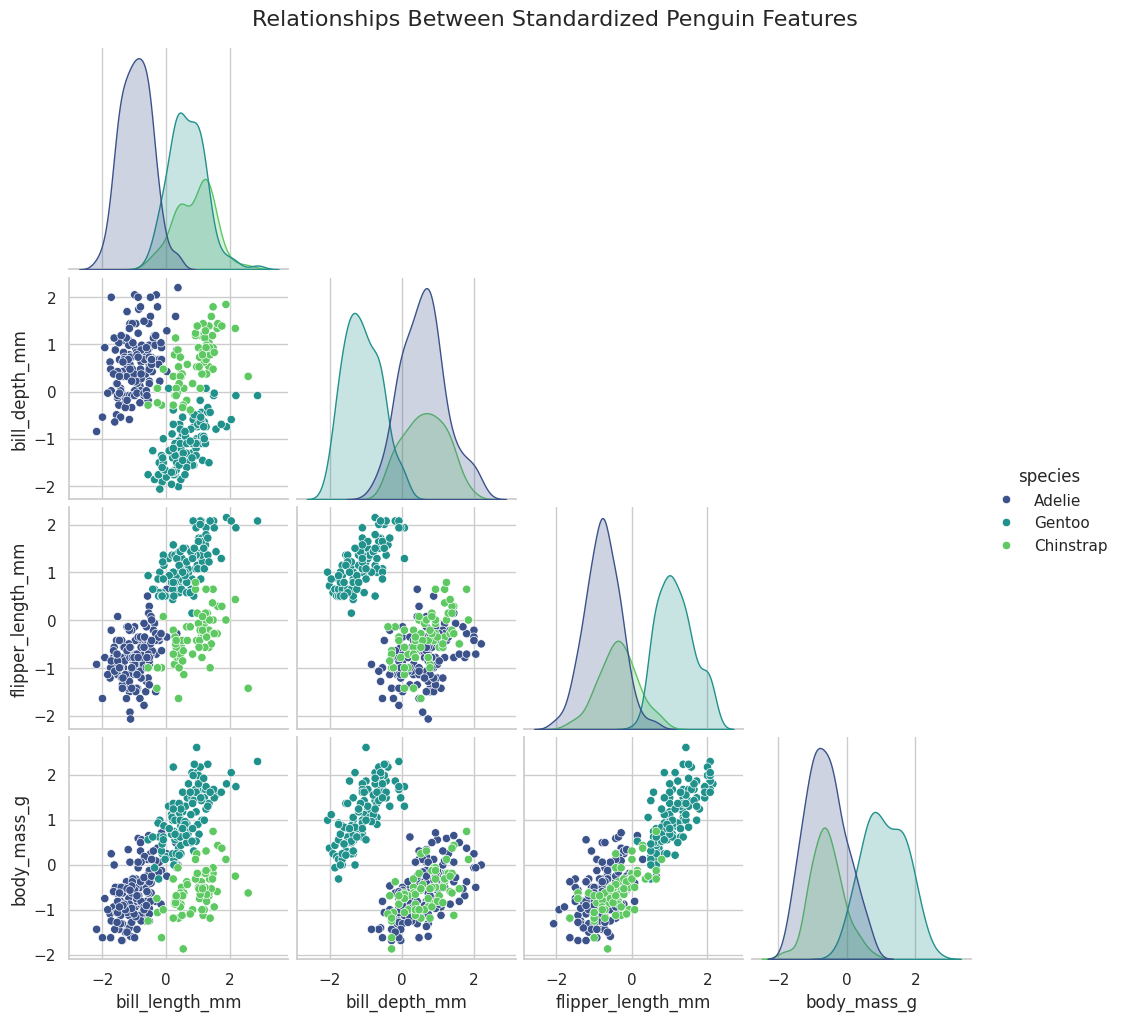

In [6]:
# Create a pairplot with scaled data to see the effect of standardization
plt.figure(figsize=(12, 10))
pairplot = sns.pairplot(
    df_scaled_penguin_data.drop("year", axis=1),
    hue="species",
    palette="viridis",
    corner=True,
)
pairplot.fig.suptitle(
    "Relationships Between Standardized Penguin Features", y=1.02, fontsize=16
)
plt.show()

# Notice that the scales of the axes have changed, but the relative positions
# and patterns remain the same. This is exactly what we want before applying UMAP.

## 3. Applying UMAP for Dimensionality Reduction

Now we'll use UMAP to reduce our 4-dimensional data (bill length, bill depth, flipper length, body mass) to a 2-dimensional representation that we can visualize.

### UMAP Parameters:

- **n_neighbors**: Controls how UMAP balances local versus global structure in the data (default=15)
- **min_dist**: Controls how tightly UMAP is allowed to pack points together (default=0.1)
- **n_components**: The dimension of the space to embed into (default=2)
- **metric**: The metric to use for distance computation (default='euclidean')

In [7]:
# Initialize UMAP with default parameters
# We could tune these parameters to get different visualizations
reducer = umap.UMAP(
    n_neighbors=15,  # Consider 15 neighbors for local structure
    min_dist=0.1,  # Minimum distance between points in the projection
    n_components=2,  # Project to 2 dimensions
    random_state=42,  # Set for reproducibility
)

print("UMAP parameters:")
print(reducer.get_params())

UMAP parameters:
{'a': None, 'angular_rp_forest': False, 'b': None, 'dens_frac': 0.3, 'dens_lambda': 2.0, 'dens_var_shift': 0.1, 'densmap': False, 'disconnection_distance': None, 'force_approximation_algorithm': False, 'init': 'spectral', 'learning_rate': 1.0, 'local_connectivity': 1.0, 'low_memory': True, 'metric': 'euclidean', 'metric_kwds': None, 'min_dist': 0.1, 'n_components': 2, 'n_epochs': None, 'n_jobs': -1, 'n_neighbors': 15, 'negative_sample_rate': 5, 'output_dens': False, 'output_metric': 'euclidean', 'output_metric_kwds': None, 'precomputed_knn': (None, None, None), 'random_state': 42, 'repulsion_strength': 1.0, 'set_op_mix_ratio': 1.0, 'spread': 1.0, 'target_metric': 'categorical', 'target_metric_kwds': None, 'target_n_neighbors': -1, 'target_weight': 0.5, 'tqdm_kwds': None, 'transform_mode': 'embedding', 'transform_queue_size': 4.0, 'transform_seed': 42, 'unique': False, 'verbose': False}


In [ ]:
# Fit the UMAP model to our data and transform it to 2D
embedding = reducer.fit_transform(scaled_penguin_data)

# Check the shape of the resulting embedding
print(f"Original data shape: {scaled_penguin_data.shape}")
print(f"Embedding shape: {embedding.shape}")

# Create a dataframe with the UMAP dimensions for easier plotting
umap_df = pd.DataFrame(
    {
        "UMAP1": embedding[:, 0],
        "UMAP2": embedding[:, 1],
        "Species": df_penguins["species"],
    }
)

# Display the first few rows of the embedding
display(umap_df.head())

/home/chris/courses/ml-in-ms-wt25/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


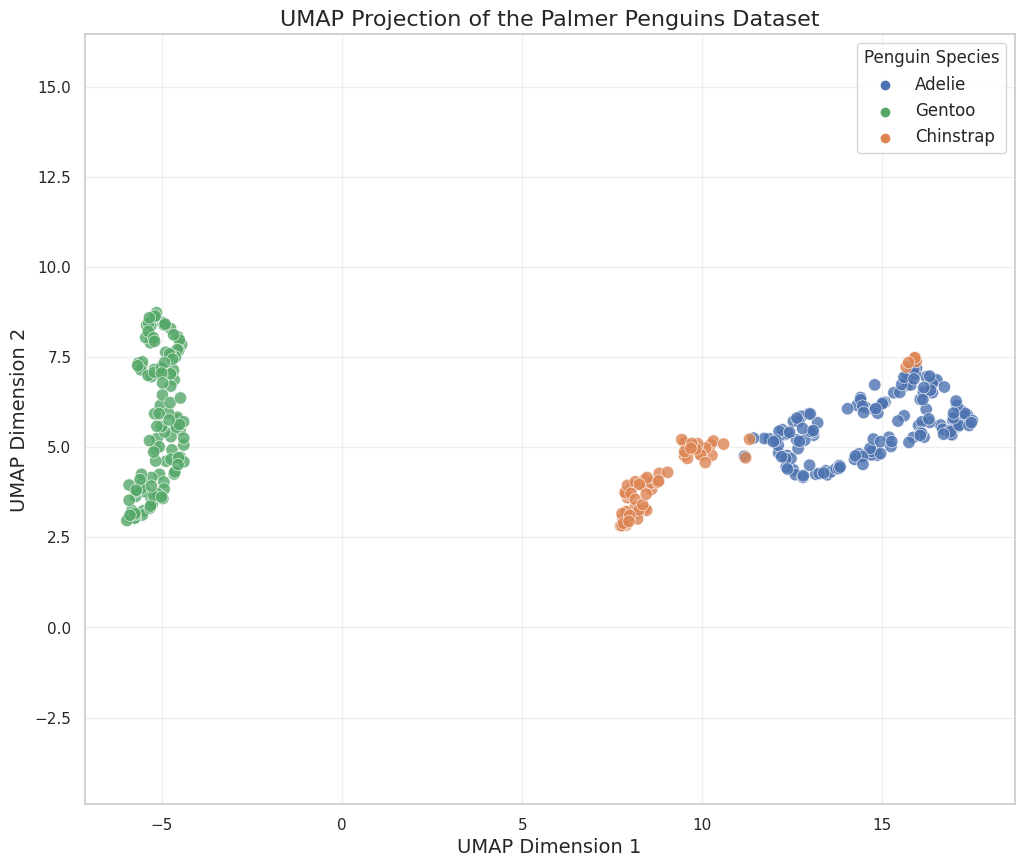

In [ ]:
# Create a color mapping for the species
species_colors = {
    "Adelie": sns.color_palette()[0],
    "Chinstrap": sns.color_palette()[1],
    "Gentoo": sns.color_palette()[2],
}

# Create a more informative visualization of the UMAP projection
plt.figure(figsize=(12, 10))

# Create the scatter plot with larger points and a legend
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[species_colors[species] for species in df_penguins.species],
    alpha=0.8,
    s=80,  # Larger point size
    edgecolor="white",  # White edges make points more distinct
    linewidth=0.5,
)

# Add labels for each point in the plot
for i, species in enumerate(df_penguins.species.unique()):
    idx = df_penguins.species == species
    plt.scatter([], [], color=species_colors[species], label=species)

# Add a legend
plt.legend(title="Penguin Species", fontsize=12)

# Set axis labels and title
plt.xlabel("UMAP Dimension 1", fontsize=14)
plt.ylabel("UMAP Dimension 2", fontsize=14)
plt.title("UMAP Projection of the Palmer Penguins Dataset", fontsize=16)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Equal aspect ratio ensures the clusters appear undistorted
plt.gca().set_aspect("equal", "datalim")

plt.show()

## 4. Interpreting the Results

The UMAP projection reveals several interesting patterns in our penguin data:

1. **Clear Species Separation**: The three penguin species form distinct clusters in the 2D projection, indicating that the physical measurements effectively differentiate between species.

2. **Cluster Insights**:
   - The Gentoo penguins (bottom cluster) are completely separated from the other two species, suggesting they have very distinctive physical characteristics.
   - Adelie and Chinstrap penguins (top clusters) show some separation but are closer to each other than to Gentoo, indicating they share more similar physical traits.

3. **Potential Outliers**: Any points that appear distant from their respective clusters could be considered outliers or unusual specimens within their species.

4. **Structure Preservation**: UMAP tries to preserve both local and global structure in the data, so the distances between the clusters suggest real biological differences between the species.

This visualization helps us understand the natural grouping of penguin species based on their physical characteristics in a way that would be impossible to see in the original 4-dimensional space.

## 5. Hands-on Exercise: Polymer Data Visualization with UMAP

In this exercise, you'll apply dimensionality reduction to polymer data to discover patterns related to crystallization tendency.

### Instructions:

1. **Data Loading**
   - Load the polymer dataset from the URL: 
     `https://raw.githubusercontent.com/kuennethgroup/materials_datasets/refs/heads/main/polymer_tendency_to_crystalize/polymers_tend_to_crystalize.json`
   - Use `pandas.read_json()` to import the data
   - Explore the data structure to identify which columns contain fingerprints and crystallization labels

2. **Data Preprocessing**
   - Apply `StandardScaler()` to normalize the fingerprint data
   - This ensures features with different magnitudes don't dominate the projection

3. **Dimensionality Reduction**
   - Use UMAP to reduce the high-dimensional fingerprints to 2D
   - Try different UMAP parameters (e.g., `n_neighbors`, `min_dist`) to optimize the visualization

4. **Visualization**
   - Create a scatter plot of the 2D UMAP projection
   - Color the points based on the crystallization tendency
   - Add appropriate labels and a title to the plot

5. **Analysis & Interpretation**
   - Examine the resulting visualization for clusters or patterns
   - Do polymers with similar crystallization tendencies group together?
   - What insights can you draw about the relationship between polymer structure and crystallization?

**Bonus:** Try comparing UMAP results with another dimensionality reduction technique like PCA or t-SNE.